#extract SDSS object IDs from galaxy zoo table 2 and match to images
#SDSS --> provides JPEG cutout images for galaxies using the 'OBJID'
  #retrieve these images using SDSS SkyServer API

In [ ]:
import os
import pandas as pd
import aiohttp
import asyncio
from tqdm.asyncio import tqdm  # This imports the tqdm version for asyncio
import nest_asyncio  # Fix for Jupyter and Colab
import random
import time
from google.colab import drive  # To mount Google Drive

# Apply nest_asyncio for Colab environment
nest_asyncio.apply()

# Mount Google Drive
drive.mount('/content/drive')

# Path to your Google Drive folder where images will be saved
output_folder = "/content/drive/MyDrive/galaxy_images"
os.makedirs(output_folder, exist_ok=True)

# Ensure required columns exist
if 'OBJID' in df.columns and 'RA' in df.columns and 'DEC' in df.columns:
    objid_list = df['OBJID']
    ra_list = df['RA']
    dec_list = df['DEC']
else:
    raise ValueError('OBJID, RA, or DEC columns not found in dataframe')

# Filter out rows where the necessary classifications are missing or invalid
df_filtered = df.dropna(subset=['P_EL', 'P_CW', 'P_ACW', 'P_EDGE', 'P_MG', 'P_DK', 'P_EL_DEBIASED', 'P_CS_DEBIASED'])

# Limit to the first 30,000 images
df_filtered = df_filtered.head(30000)

# Async function to download image with retries
async def download_image(session, objid, ra, dec):
    url = f"https://skyserver.sdss.org/dr16/SkyServerWS/ImgCutout/getjpeg?TaskName=Skyserver.Explore.Image&ra={ra}&dec={dec}&scale=0.2&width=256&height=256"
    filename = f"{output_folder}/galaxy_{objid}.jpg"

    if os.path.exists(filename):  # Skip if already downloaded
        return None

    for attempt in range(3):  # Retry up to 3 times
        try:
            async with session.get(url, timeout=30) as response:  # Set a timeout for each request
                if response.status == 200:
                    with open(filename, "wb") as f:
                        f.write(await response.read())
                    return filename
                else:
                    print(f"Error: Failed for {objid}, Status: {response.status}")
        except asyncio.TimeoutError:
            print(f"TimeoutError: Retrying {objid}...")
        except Exception as e:
            print(f"Error downloading {objid}: {e}")

        # Wait for a random amount of time before retrying (backoff strategy)
        time.sleep(random.uniform(1, 3))

    return None  # If all retries fail

# Async function to handle batch downloads
async def download_all_images():
    async with aiohttp.ClientSession() as session:
        tasks = []
        total_images = len(df_filtered)  # Total images to download
        with tqdm(total=total_images, desc="Downloading Images", unit="image") as pbar:
            for _, row in df_filtered.iterrows():
                objid = row['OBJID']
                ra = row['RA']
                dec = row['DEC']
                tasks.append(download_image(session, objid, ra, dec))
                if len(tasks) >= 10:  # Limit to 10 concurrent downloads
                    completed = await asyncio.gather(*tasks)
                    tasks = []  # Reset for next batch
                    pbar.update(len(completed))  # Update progress bar after a batch is completed
            # Final batch
            if tasks:
                completed = await asyncio.gather(*tasks)
                pbar.update(len(completed))  # Update progress bar after the final batch

    print(f"✅ Download complete. Images saved to '{output_folder}'.")

# Run async downloader in Google Colab
await download_all_images()


Mounted at /content/drive


NameError: name 'df' is not defined

In [ ]:
#creare a DF linking the downloaded images to the classifications from original df
output_folder = "/content/drive/MyDrive/galaxy_images"
image_list = []
for _, row in df.iterrows():
  objid = row['OBJID']
  filename = f'galaxy_{objid}.jpg'
  file_path = os.path.join(output_folder, filename)

  if os.path.exists(os.path.join(output_folder, filename)):
    image_list.append({
        'image_path': file_path,
        'OBJID': objid,
        'RA': row['RA'],
        'DEC': row['DEC'],
        'P_EL': row['P_EL'],
        'P_CW': row['P_CW'],
        'P_ACW': row['P_ACW'],
        'P_EDGE': row['P_EDGE'],
        'P_MG': row['P_MG'],
        'P_DK': row['P_DK'],
        'P_EL_DEBIASED': row['P_EL_DEBIASED'],
        'P_CS_DEBIASED': row['P_CS_DEBIASED']
    })

#convert to DF
image_df = pd.DataFrame(image_list)

#save csv for model training
csv_path = os.path.join(output_folder, 'galaxy_image_labels.csv')
image_df.to_csv(csv_path, index=False)


print(f'created dataset: galaxy_image_labels.csv ({len(image_df)} images linked!)')

NameError: name 'df' is not defined

KeyError: 'image_path'

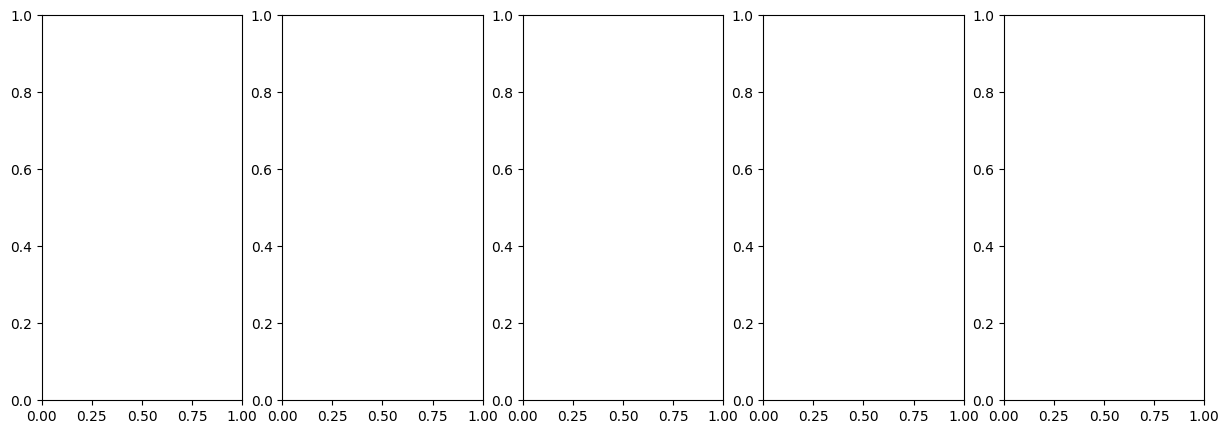

In [ ]:
# Visualize some images
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, ax in enumerate(axes):
    img_path = df.iloc[i]['image_path']
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for Matplotlib
    ax.imshow(img)
    ax.set_title(f"Galaxy {df.iloc[i]['OBJID']}")
    ax.axis('off')
plt.show()

## Main Goals of Project
1. use image data and galaxy zoo probabilities to train a CNN that learns to predict the morphological features of galaxies
2. this helps scale up analysis in astro and reduce dependency on manual labeling (which is slow and subjective)
3. frame task as multi-output regression --> learn a nuanced, flexible model that reflects the cont and uncertain nature of galaxy classification
4. Use XAI techniques to determine and visualize what parts of teh galaxy images the CNN is focussing on --> provide interpretability and insight into the model's decision making

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2

# EXTRACTING DATA

In [ ]:
#DOWNLOAD CLASSIFICATION TABLE (from drive)
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')

df = pd.read_csv('/content/drive/My Drive/Machine Learning/GalaxyZoo1_DR_table2.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#print(df.head())
cols = df.columns
print(cols)

Index(['OBJID', 'RA', 'DEC', 'NVOTE', 'P_EL', 'P_CW', 'P_ACW', 'P_EDGE',
       'P_DK', 'P_MG', 'P_CS', 'P_EL_DEBIASED', 'P_CS_DEBIASED', 'SPIRAL',
       'ELLIPTICAL', 'UNCERTAIN'],
      dtype='object')


In [ ]:
print(f"Filtered dataframe length: {len(df)}")


Filtered dataframe length: 667944


# Preprocess the Data
- resize all images (128 x 128)
- normalize pixel values (0-1 range)
- augment the dataset with flips/rotations/etc --> maybe)

In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/Machine Learning/galaxy_image_labels.csv')
df.head()



,image_path,OBJID,RA,DEC,P_EL,P_CW,P_ACW,P_EDGE,P_MG,P_DK,P_EL_DEBIASED,P_CS_DEBIASED
0,/content/drive/MyDrive/galaxy_images/galaxy_58...,587727178986356823,00:00:00.41,-10:22:25.7,0.610,0.034,0.000,0.153,0.051,0.153,0.610,0.186
1,/content/drive/MyDrive/galaxy_images/galaxy_58...,587727227300741210,00:00:00.74,-09:13:20.2,0.611,0.000,0.167,0.222,0.000,0.000,0.203,0.797
2,/content/drive/MyDrive/galaxy_images/galaxy_58...,587727225153257596,00:00:01.03,-10:56:48.0,0.735,0.029,0.000,0.147,0.015,0.074,0.432,0.428
3,/content/drive/MyDrive/galaxy_images/galaxy_58...,587730774962536596,00:00:01.38,+15:30:35.3,0.885,0.019,0.000,0.058,0.019,0.019,0.885,0.077
4,/content/drive/MyDrive/galaxy_images/galaxy_58...,587731186203885750,00:00:01.55,-00:05:33.3,0.712,0.000,0.000,0.220,0.000,0.068,0.640,0.290


In [ ]:
import os

# Remove rows where image file doesn't exist
df = df[df['image_path'].apply(lambda x: os.path.exists(x))].reset_index(drop=True)


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
#use a small sample to tune model to start
df_debug = df.sample(n=2000, random_state=42).reset_index(drop=True)


In [ ]:
#creating an imagedatagenerator
datagen = ImageDataGenerator(
    rescale = 1./255, #normalizes pixel values to range 0-1

    #data sugmentation techniques --> introduce variation into tr data
    #leads to better generalization by model and to avoid overfitting
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip = True,
    validation_split=0.2  # use part of the data for validation
)

#define the image size
IMG_SIZE = (128,128)
BATCH_SIZE = 32 # num images to be processed in each batch during training

#training data generator-->generates batches of augmented image data and corresponding labels for training models
train_generator = datagen.flow_from_dataframe(
    dataframe = df, #CHANGE TO FULL DATA SET WHEN READY!!!!!!!!!!!
    x_col='image_path', #col in DF that contains paths to images

    #adjust y_col depending on label i want to predict (target variables)
    y_col=['P_EL_DEBIASED', 'P_CS_DEBIASED', 'P_MG', 'P_EDGE'],  # selected features only
    target_size = IMG_SIZE,
    batch_size = BATCH_SIZE,

    #indicates that the target variables are numerical values
    class_mode = 'raw', #change based on classification
    subset='training',
    shuffle=True

)

# Validation generator
val_gen = datagen.flow_from_dataframe(
    df, #CHANGE TO FULL DATASET WHEN READY!!!!!!
    x_col='image_path',
    y_col=['P_EL_DEBIASED', 'P_CS_DEBIASED', 'P_MG', 'P_EDGE'],
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='raw',
    subset='validation',
    shuffle=False
)

Found 24000 validated image filenames.
Found 6000 validated image filenames.


## Build a SIMPLE CNN Model  for Multi-Output Regression

- since targets are continuous values between 0 and 1, this is a regression task, NOT a classification task
- we ar epredicitng cols that are probabilities b/w 0 and 1, not hard class labels like spiral, elliptical, etc.

In [ ]:
#step 1: predict 8 continuous outputs for each image
#   - loss: MSE ot Mean absolute error
#   - Output layer: dense(8, activation='sigmoid') bc targets are in [0,1]
#   - input shape: 128,128,3 = RBG (3 channels), 128x128 pixels dim

import tensorflow as tf
from tensorflow.keras import layers, models

def build_CNN(input_shape=(128, 128, 3)):
  model = models.Sequential([
      #define input shape of imaages to the model
      layers.InputLayer(input_shape=input_shape),

      #applies 32 filters of size 3x3 to learn features like edges/textures
      layers.Conv2D(32, (3,3), activation='relu'),
      #downsamples the feature maps by taking the max in 2x2 patches
      layers.MaxPooling2D((2,2)),

      #increases depth to 64 filters now, learns more complex feautes
      layers.Conv2D(64, (3,3), activation='relu'),
      layers.MaxPooling2D((2,2)),

      #128 filters now --> even deeper features, object parts/combo of features
      layers.Conv2D(128, (3,3), activation='relu'),
      layers.MaxPooling2D((2,2)),

      #convert final 3d output od convolution layers to a 1d vector
      layers.Flatten(),
      layers.Dense(128, activation='relu'), #fully connected layer with 128 neurons
      layers.Dense(8, activation='sigmoid') #final layer that outputs 8 values
  ])

  return model


In [ ]:
#step 2: compile the model
#   - start w Adam (efficient default)
#   - mean absolute error is easy to interpret

model = build_CNN()

model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mae']
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [ ]:
#step 3: train the model

history = model.fit(
    train_generator,
    epochs=2, #fast testing --> increase once hyperparam tuning is done
    validation_data=val_gen,
    steps_per_epoch=100, #fast testing --> increase once hyperparam tuning is done
    verbose=1
)

In [ ]:
#step 4: evaluate performance
#   - plot loss and MAE over time

import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.legend()
plt.title('Fast Debug Training')
plt.show()


# HYPERMARAM TUNING!!!
### Find the best model




In [ ]:
#step 5: Tune the model
#   optimize by:
#   - add/drop Conv2D layers
#   - increase filter sizes
#   - try BatchNormalization and Dropout
#   Tune:
#   - earning rate
#   - batch size
#   - epochs (go up if underfitting)
#   - try loss = 'mae' vs loss = 'mse'

import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras import layers

def build_model(hp):
  model = keras.Sequential()
  model.add(layers.InputLayer(input_shape=(128,128, 3)))

  #convolution layers
  for i in range(hp.Int('conv_blocks', 1, 3)):
    model.add(layers.Conv2D(
        filters = hp.Int(f'filters_{i}', 16, 128, step=16),
        kernel_size = hp.Choice(f'kernel_size_{i}', values=[3,]),
        activation='relu'
    ))
    model.add(layers.MaxPooling2D((2,2)))

  model.add(layers.Flatten())

  #dense layer
  model.add(layers.Dense(
      units=hp.Int('dense_units', 64, 256, step=32),
      activation='relu'
  ))

  #dropout
  model.add(layers.Dropout(hp.Float('dropout', 0.0, 0.5, step=0.1)))

  #output layer
  model.add(layers.Dense(8, activation='sigmoid'))

  #compile
  model.compile(
      optimizer=keras.optimizers.Adam(
          hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
      ),
      loss='mean_squared_error',
      metrics=['mae']
  )

  return model



ModuleNotFoundError: No module named 'keras_tuner'

In [ ]:
#set up tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=10,
    factor=3,
    directory='my_dir',
    project_name='galaxy_classification'
)

NameError: name 'kt' is not defined

In [ ]:
#run the search
tuner.search(train_generator, epochs=10, validation_data=val_gen, steps_per_epoch=100)

In [ ]:
#get the BEST model
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparams = tuner.get_best_hyperparameters(num_trials=1)[0]

print('Best Hyperparameters:')
for param in best_hyperparams.values:
  print(f'{param}: {best_hyperparams[param]}')

In [ ]:
#save the best model
best_model.save('/content/drive/MyDrive/Machine Learning/best_galaxy_model')

#save best hyperparams
best_hp = tuner.get_best_hyperparameters(1)[0]
with open('/content/drive/MyDrive/best_galaxy_hyperparams.txt', 'w') as f:
    for param in best_hp.values:
        f.write(f"{param}: {best_hp.get(param)}\n")

## Apply best hyperparms to full dataset!

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

def build_final_CNN():
  model = models.Sequential()
  model.add(layers.InputLayer(input_shape=(128,128,3)))

  #conv block 0
  model.add(layers.Conv2D(80, (3,3), activation='relu'))
  model.add(layers.MaxPooling2D((2,2)))

  #conv block 1
  model.add(layers.Conv2D(112, (3,3), activation='relu'))
  model.add(layers.MaxPooling2D((2,2)))

  #conv block 2
  model.add(layers.Conv2D(64, (3,3), activation='relu'))
  model.add(layers.MaxPooling2D((2,2)))


  model.add(layers.Flatten())
  model.add(layers.Dense(192, activation='relu'))
  model.add(layers.Dropout(0.1))
  model.add(layers.Dense(8, activation='sigmoid'))

  optimizer = optimizers.Adam(learning_rate=0.0008053201250101636)
  model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

  return model

model = build_final_CNN()
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 80)   │         2,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 80)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 112)    │        80,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 112)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 64)     │        64,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 192)            │     2,408,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,544 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,557,752 (9.76 MB)

 Trainable params: 2,557,752 (9.76 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras import layers, models, optimizers

def build_final_functional_model():
    inputs = layers.Input(shape=(128, 128, 3))

    x = layers.Conv2D(80, (3, 3), activation='relu')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(112, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Flatten()(x)
    x = layers.Dense(192, activation='relu')(x)
    x = layers.Dropout(0.1)(x)

    outputs = layers.Dense(4, activation='sigmoid')(x)  # 4 regression outputs now

    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=optimizers.Adam(learning_rate=8.05e-4),
        loss='mean_squared_error',
        metrics=['mae']
    )
    return model


In [ ]:
model = build_final_functional_model()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Automatically save the best model during training
checkpoint = ModelCheckpoint(
    filepath='/content/drive/MyDrive/Machine Learning/best_final_model.keras',              # or 'best_model.keras' if you're using .keras format
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)
# Train WITHOUT ModelCheckpoint
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=val_gen,
    steps_per_epoch=100,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

# After training finishes (whether early or after all epochs),
# Save the final model

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - loss: 0.0691 - mae: 0.2015
Epoch 1: val_loss improved from inf to 0.04653, saving model to best_final_model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 2616s 26s/step - loss: 0.0690 - mae: 0.2013 - val_loss: 0.0465 - val_mae: 0.1530
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.0468 - mae: 0.1558
Epoch 2: val_loss improved from 0.04653 to 0.04216, saving model to best_final_model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 1003s 10s/step - loss: 0.0468 - mae: 0.1557 - val_loss: 0.0422 - val_mae: 0.1489
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - loss: 0.0407 - mae: 0.1436
Epoch 3: val_loss improved from 0.04216 to 0.03872, saving model to best_final_model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 862s 9s/step - loss: 0.0407 - mae: 0.1436 - val_loss: 0.0387 - val_mae: 0.1429
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 0.0358 - mae: 0.1317
Epoch 4: val_loss did not improve from 0.03872
100/100 ━━━━━━━━━━━━━━━━━━━━ 738s 7

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 8: val_loss improved from 0.03122 to 0.02933, saving model to best_final_model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 291s 3s/step - loss: 0.0319 - mae: 0.1216 - val_loss: 0.0293 - val_mae: 0.1185
Epoch 9/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 0.0264 - mae: 0.1117
Epoch 9: val_loss improved from 0.02933 to 0.02621, saving model to best_final_model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 543s 5s/step - loss: 0.0264 - mae: 0.1117 - val_loss: 0.0262 - val_mae: 0.1099
Epoch 10/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.0258 - mae: 0.1108
Epoch 10: val_loss improved from 0.02621 to 0.02494, saving model to best_final_model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 490s 5s/step - loss: 0.0258 - mae: 0.1108 - val_loss: 0.0249 - val_mae: 0.1097
Epoch 11/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.0243 - mae: 0.1066
Epoch 11: val_loss improved from 0.02494 to 0.02255, saving model to best_final_model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 449s 5s/step - loss: 0.0243 - mae: 0.1

In [ ]:
model.save('/content/drive/MyDrive/Machine Learning/final_functional_model_4_output.keras')


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Automatically save the best model during training
checkpoint = ModelCheckpoint(
    filepath='best_final_model.keras',              # or 'best_model.keras' if you're using .keras format
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)
# Train WITHOUT ModelCheckpoint
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=val_gen,
    steps_per_epoch=100,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

# After training finishes (whether early or after all epochs),
# Save the final model


Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - loss: 0.0510 - mae: 0.1574 
Epoch 1: val_loss improved from inf to 0.04342, saving model to best_final_model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 3054s 31s/step - loss: 0.0510 - mae: 0.1574 - val_loss: 0.0434 - val_mae: 0.1583
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - loss: 0.0426 - mae: 0.1424
Epoch 2: val_loss improved from 0.04342 to 0.04012, saving model to best_final_model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 1064s 11s/step - loss: 0.0426 - mae: 0.1423 - val_loss: 0.0401 - val_mae: 0.1242
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.0362 - mae: 0.1276
Epoch 3: val_loss improved from 0.04012 to 0.03310, saving model to best_final_model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 947s 10s/step - loss: 0.0362 - mae: 0.1276 - val_loss: 0.0331 - val_mae: 0.1242
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 0.0325 - mae: 0.1201
Epoch 4: val_loss improved from 0.03310 to 0.03276, saving model to best_final_m

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 8: val_loss improved from 0.02748 to 0.02675, saving model to best_final_model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 311s 3s/step - loss: 0.0265 - mae: 0.1062 - val_loss: 0.0268 - val_mae: 0.1068
Epoch 9/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 0.0277 - mae: 0.1098
Epoch 9: val_loss improved from 0.02675 to 0.02567, saving model to best_final_model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 594s 6s/step - loss: 0.0277 - mae: 0.1098 - val_loss: 0.0257 - val_mae: 0.1031
Epoch 10/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.0255 - mae: 0.1050
Epoch 10: val_loss improved from 0.02567 to 0.02558, saving model to best_final_model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 526s 5s/step - loss: 0.0255 - mae: 0.1050 - val_loss: 0.0256 - val_mae: 0.1031
Epoch 11/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.0236 - mae: 0.0995
Epoch 11: val_loss improved from 0.02558 to 0.02285, saving model to best_final_model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 493s 5s/step - loss: 0.0236 - mae: 0.0

In [ ]:
# Save final model
model.save('/content/drive/MyDrive/Machine Learning/final_tuned_functional.keras')




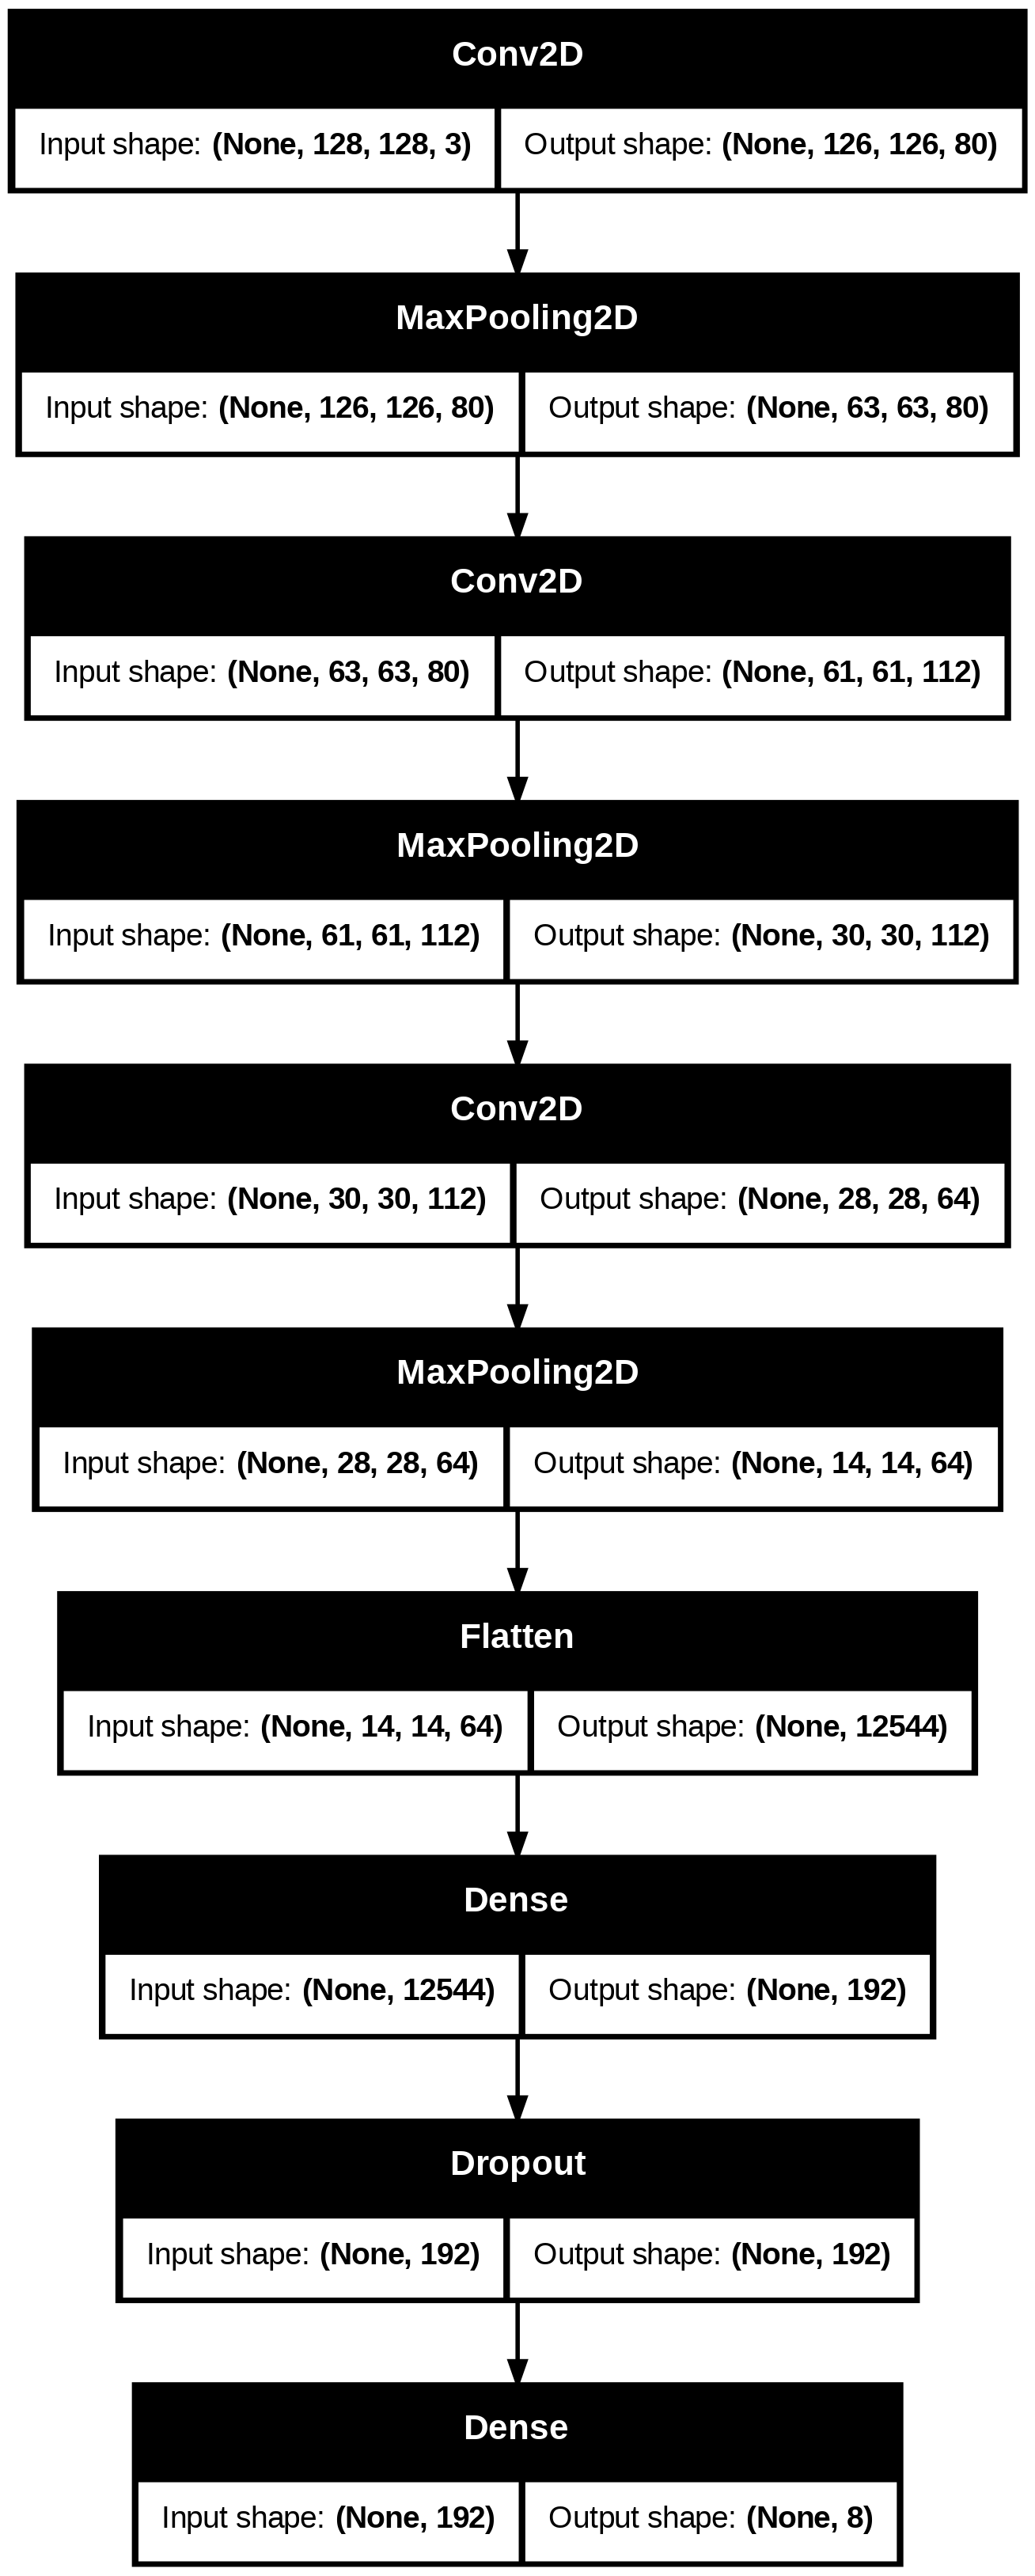

In [ ]:
klm,,mfrom tensorflow.keras.utils import plot_model

plot_model(model, to_file='/content/drive/MyDrive/final_model_architecture.png', show_shapes=True)


In [ ]:
# Save model in new Keras format
model.save('/content/drive/MyDrive/Machine Learning/final_tuned_model.keras', save_format='keras')


NameError: name 'model' is not defined